In [ ]:
import tensorflow as tf
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
%pylab inline

# Intro
In current notebook I show implementation of Gradient Descent (GD) with tensorflow for Simple Linear Regression and visualize the optimization process.

# Data

Liner Regression Solution:
 b_0=0.000 b_1=0.928
 SSE=6.93


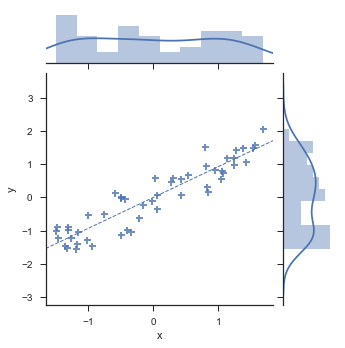

In [90]:
def generate_data(intercept=1, slope=0.8, n=50, normalize=False):
    np.random.seed(11)
    x = np.random.uniform(low=-1, high=1, size=n)
    noise_scale = (x.max()-x.min()) / 10
    noise = np.random.normal(loc=0, scale=noise_scale, size=n)
    y = intercept + slope*x + noise
    # normalization #
    # Using non normalized data cause to bad SGD convergence. 
    if normalize:
        norm = lambda vec: (vec - vec.mean()) / vec.std()
        x, y = norm(x), norm(y)
    return x, y
x, y = generate_data(normalize=True) 
data_df = pd.DataFrame({'x':x, 'y':y})

# data visualisation
sns.set(style="ticks")
g = sns.JointGrid(x='x', y='y', data=data_df, size=5, ratio=4)
_ = g.plot_joint(sns.regplot, marker='P', ci=None, line_kws={'ls':'--', 'lw':1})
_ = g.plot_marginals(sns.distplot, bins=10)

# simple linear regression solution
reg_sol = stats.linregress(x, y)
SSE = lambda y, y_pred: np.sum((y-y_pred)**2)
# y_pred = b_0 + b_1*x
y_pred = reg_sol.intercept + reg_sol.slope * x
print('Liner Regression Solution:\n b_0=%.3f b_1=%.3f\n SSE=%.2f' %(reg_sol.intercept, reg_sol.slope, SSE(y, y_pred)))

# SGD with TF

In [ ]:
def sgd_solution (x_data, y_data, n_iter, learning_rate, print_st=1):
    # slope and intercept initial value
    init_val = -2.0
    b_0 = tf.Variable(init_val, tf.float32)
    b_1 = tf.Variable(init_val, tf.float32)
    
    # Linear Model definition
    x = tf.placeholder(tf.float32)
    y = tf.placeholder(tf.float32)
    lm = b_0 + b_1*x
    
    # SSE loss  - the same metric as Linear Regression use 
    sse_loss = tf.reduce_sum(tf.square(lm-y))
    # optimizer
    opt = tf.train.GradientDescentOptimizer(learning_rate)
    # opt = tf.train.AdagradOptimizer(learning_rate)   # possible to use different GD variations
    # opt = tf.train.AdamOptimizer(learning_rate)
    train = opt.minimize(sse_loss)
    
    # training #
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    ans = []  # intermidiate values of estimated b0, b1 and SSE value
    ans.append(sess.run([b_0, b_1, sse_loss], {x:x_data, y:y_data})) # initial values
    print('initial state')
    print('b0=%.3f  b1=%.3f  sse=%.3f\n' %(ans[0][0], ans[0][1], ans[0][2]))
    # perform SGD iterations 
    for i in range(n_iter):
        sess.run(train, {x:x_data, y:x_data})
        if i%print_st==0:
            ans_i = sess.run([b_0, b_1, sse_loss], {x:x_data, y:y_data})
            print('iter %d' %(i+1))
            print('b0=%.3f  b1=%.3f  sse=%.3f' %(ans_i[0], ans_i[1], ans_i[2]))
            ans.append(ans_i)
    return ans

In [87]:
sgd_ans = sgd_solution(x, y, n_iter=10, learning_rate=0.005, print_st=1)

initial state
b0=-2.000  b1=-2.000  sse=635.622

iter 1
b0=-1.000  b1=-0.500  sse=158.905
iter 2
b0=-0.500  b1=0.250  sse=42.422
iter 3
b0=-0.250  b1=0.625  sse=14.649
iter 4
b0=-0.125  b1=0.812  sse=8.380
iter 5
b0=-0.062  b1=0.906  sse=7.150
iter 6
b0=-0.031  b1=0.953  sse=7.011
iter 7
b0=-0.016  b1=0.977  sse=7.060
iter 8
b0=-0.008  b1=0.988  sse=7.115
iter 9
b0=-0.004  b1=0.994  sse=7.149
iter 10
b0=-0.002  b1=0.997  sse=7.169


# Gradient Descent Vizualization

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
          
def plot_sse(x, y, sgd_ans):
    # Prepare data for ploting #
    # grid of b0, b1 values
    b0 = np.arange(-2, 3, .01)
    b1 = np.arange(-2, 3, .01)
    b0_, b1_ = np.meshgrid(b0, b1)
    
    # calculate SSE values for each values b0 and b1
    sse_vals = np.zeros((len(b0), len(b0)))
    for i in range(len(b0)):
        for j in range(len(b0)):
            y_predict = b0_[i][j] + b1_[i][j]*x
            sse_vals[i][j] = SSE(y, y_predict)
    
    # Plot #
    fig = plt.figure(figsize=(12, 8)) # with/ high
    ax = fig.gca(projection='3d')
    # SSE surface
    surf = ax.plot_surface(b1_, b0_, sse_vals,
                    alpha=0.35, cmap=cm.coolwarm, linewidth=0, antialiased=False,
                    rstride=20, cstride=20)
    # SSE contours
    cset = ax.contour(b1_, b0_, sse_vals, zdir='z',
                      levels=[15, 50, 125, 200, 300],
                      offset=-200, cmap=cm.coolwarm)
    # plot labels
    ax.set_xlabel('b1', size='large', labelpad=10)
    ax.set_xlim(-2, 3)
    ax.set_ylabel('b0', size='large', labelpad=10)
    ax.set_ylim(-2, 3)
    ax.set_zlabel('SSE', size='large', labelpad=10)
    ax.set_zlim(-200, 1000)
    fig.colorbar(surf, shrink=0.5, aspect=30, pad=0.01)
    
    # Gradient iterations - black triangles #
    sgd_ans = np.array(sgd_ans)
    sgd_b0, sgd_b1, sgd_sse = sgd_ans[:,[0]], sgd_ans[:,[1]], sgd_ans[:,[2]]
    ax.plot(sgd_b1, sgd_b0, [-200]*len(sgd_b0), '>k', label='GD iterations')
    
    # Linear Regression Solution (SSE minimum) - red star #
    reg_sol = stats.linregress(x, y)
    ax.plot([reg_sol.slope], [reg_sol.intercept], [-200], '*r', ms=15, alpha=0.8, label='SSE min')
    
    ax.legend(loc=0)
    plt.show()
    # return b0, b1, sse_vals


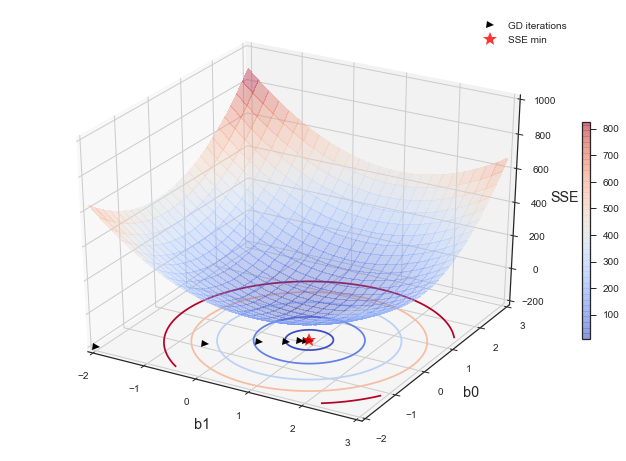

In [89]:
#after 6 iters the optimization has converged
plot_sse(x, y, sgd_ans[:7])